# Time-delayed bias-probability analysis 

In [29]:
# Loading packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.io
import scipy.signal
import os
from datetime import date
%matplotlib notebook
import scipy.io
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette("dark")
c0 = 299792458
ħ = 1.054571817e-34
h = 6.626e-34
eps0 = 8.8541878128e-12
bias_color = sns.color_palette("tab10")[1]
# bias_color = (255,20,46)
from matplotlib.gridspec import GridSpec

# Nominal values 

In [30]:
# Fitting functions 
def fitting(x,b,phi):
    ang=2*np.pi*x/360+phi
    exp_arg = np.cos(2*ang)*b
    res=np.exp(exp_arg)/(np.exp(exp_arg)+np.exp(-exp_arg))
    return(res)

def sigmoid(x,b):
    exp_arg = 0.5*x*b
    return np.exp(exp_arg)/(np.exp(exp_arg)+np.exp(-exp_arg))

def logit(x):
    # Now inverse of erf function 
    return 0.5*scipy.special.erfinv(2*x-1)

def sin_func(x, a, b, c, d):
    return a+np.multiply(b, np.sin(np.multiply(c,x)+d))

In [31]:
# Input pulse is sech with measured τ_p (FWHM) by Toptica
def sech(x):
    return 1.0/np.cosh(x)

def pulse_func_sech(t, a, t0, λ0, fwhm, phi):
    # Input pulse is sech with measured τ_p (FWHM) by Toptica
    
    τ_p = fwhm # in femtoseconds 
    τ_s = τ_p/1.763 # From Ultrafast textbook 

    T = λ0/c0

    pul_int_theory = sech((t-t0)/τ_s)**2. # Formula comes from Ultrafast textbook (Table)

    # Time domain field (initial)
    pul_Et_theory = np.sqrt(pul_int_theory)
    
    pulse = a*pul_Et_theory*(np.exp(1j*t*(2*np.pi/T)+1j*phi))
    return pulse    

def pulse_func_sech_chirped(t, a, t0, λ0, fwhm, phi, chirp):
    # Input pulse is sech with measured τ_p (FWHM) by Toptica
    
    τ_p = fwhm # in femtoseconds 
    τ_s = τ_p/1.763 # From Ultrafast textbook 

    T = λ0/c0

    pul_int_theory = sech((t-t0)/τ_s)**2. # Formula comes from Ultrafast textbook (Table)

    # Time domain field (initial)
    pul_Et_theory = np.sqrt(pul_int_theory)
    
    pulse = np.real(a*pul_Et_theory*(np.exp(1j*t*(2*np.pi/T+chirp*t)+1j*phi)))
    return pulse    

def pulse_func_sech_envelope(t, a, t0, fwhm):
    # Just envelope, since λ and ϕ are silent, they are set to some arbitrary values
    return np.abs(pulse_func_sech(t, a, t0, λ_laser, fwhm, 0.))

In [32]:
# Absolute value calibration
pulse_duration = 190e-15 #fwhm (s)
refind = 2.2 # approximate -- value from refractiveindex.info
beam_area = np.pi*(10e-6)**2. # in m^2
L_mode = pulse_duration*c0 # Rayleigh range 
λ0 = 1544e-9
ω0 = 2*np.pi*c0/λ0

def btoE(b):
    return b*np.sqrt(1./(eps0*c0*refind*beam_area/2.*pulse_duration/(ħ*ω0)))

# Piezo calibration

In [33]:
path = os.getcwd()+"/piezo-cal" # Path to piezo calibration data 
piezo_cal_data = np.load(path+"/calibration_result_3tick_back_long_sweep.npy") # Piezo calibration data

λ_laser = 1550e-9 # in meters 
pos = piezo_cal_data[0] 
interf = piezo_cal_data[1] - np.mean(piezo_cal_data[1])

peaks, _ = find_peaks(interf, height = 0., distance = 8)
mean_p2p = np.mean(np.abs(np.diff(pos[peaks])))
std_p2p = np.std(np.abs(np.diff(pos[peaks])))
print('Extracted peak-to-peak (1550 nm) {0} +\- {1}'.format(mean_p2p, std_p2p))
piezo_step_size = np.abs((λ_laser)/(mean_p2p)/2.)
piezo_step_size_error = (np.abs((λ_laser)/(mean_p2p-std_p2p)/2.) - np.abs((λ_laser)/(mean_p2p+std_p2p)/2.))/2.
print('Piezo step size = {0} nm ({1} fs))'.format(piezo_step_size*1e9, piezo_step_size/c0*1e15))
print('Piezo step size error = {0}'.format(piezo_step_size_error))

Extracted peak-to-peak (1550 nm) 81.30841121495327 +\- 4.181425806447783
Piezo step size = 9.531609195402298 nm (0.031794025970467536 fs))
Piezo step size error = 4.91479323463844e-10


# Experimental data 

<IPython.core.display.Javascript object>


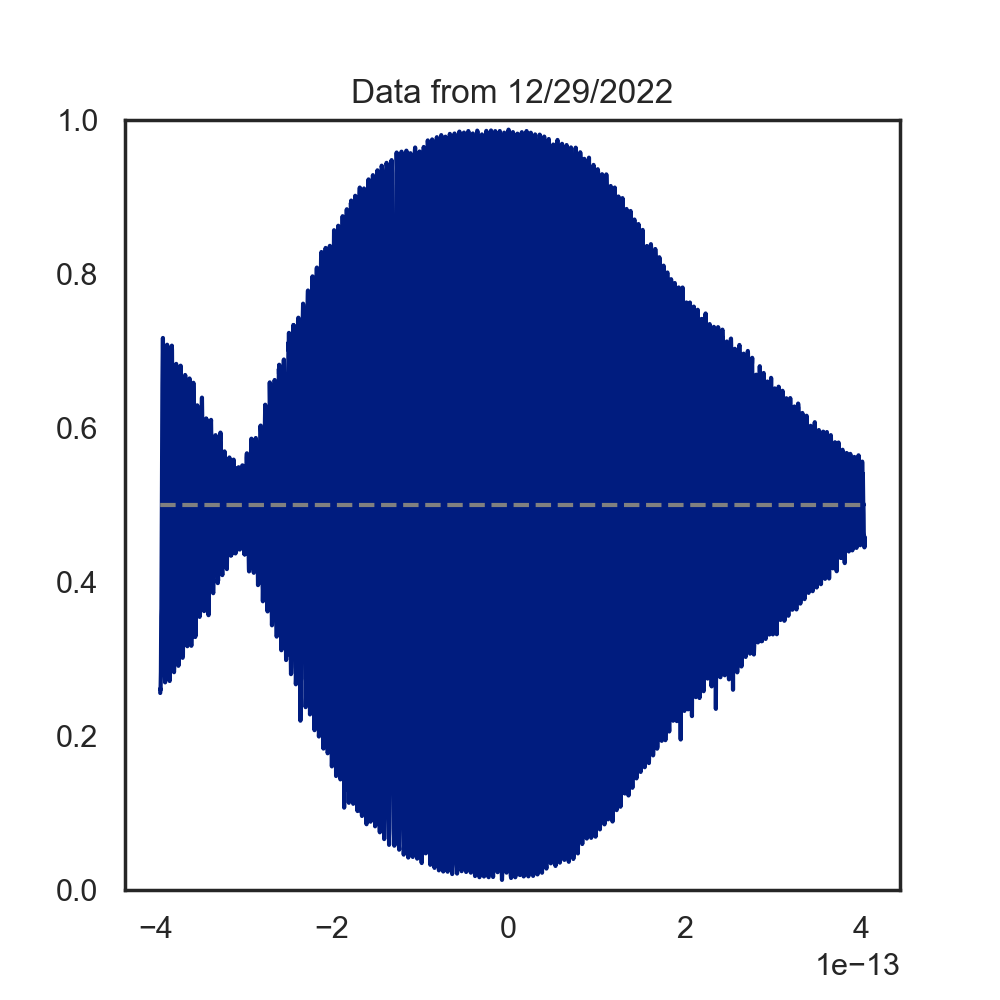

Text(0.5, 1.0, 'Data from 12/29/2022')

In [34]:
path = "piezo-cal/1229result_total.npy"
data = np.load(path)

expt_probs = data[1] # Probabilities
expt_times = data[0] # Times (in piezo location)

# Re-calibrating time vector 
# expt_times = expt_times - expt_times[np.where(np.min(np.abs(expt_times)))]
expt_times = expt_times - expt_times[np.where(np.max(np.abs(expt_probs))==expt_probs)]
expt_times = expt_times * piezo_step_size  / c0 * 2

## REMOVES SIDE LOBES FOR DATA ANALYSIS. NEED TO BE ADDRESSED LATER
cutoff_time_left = -np.inf
# cutoff_time_left = -300e-15
cutoff_ind_left = np.where(np.abs(expt_times-cutoff_time_left)==np.min(np.abs(expt_times-cutoff_time_left)))[0][0]
expt_times = expt_times[cutoff_ind_left:]
expt_probs = expt_probs[cutoff_ind_left:]

# Reconstruct field from probability
field_recons = logit(expt_probs)
field_recons = btoE(field_recons)/1e3 # UNITS = kV/m

plt.figure(figsize = (5,5))
plt.plot(expt_times, expt_probs)
plt.plot(expt_times, np.ones_like(expt_probs)*0.5, '--', color = 'grey')
plt.ylim(0.0,1.0)
plt.title("Data from 12/29/2022")

<IPython.core.display.Javascript object>


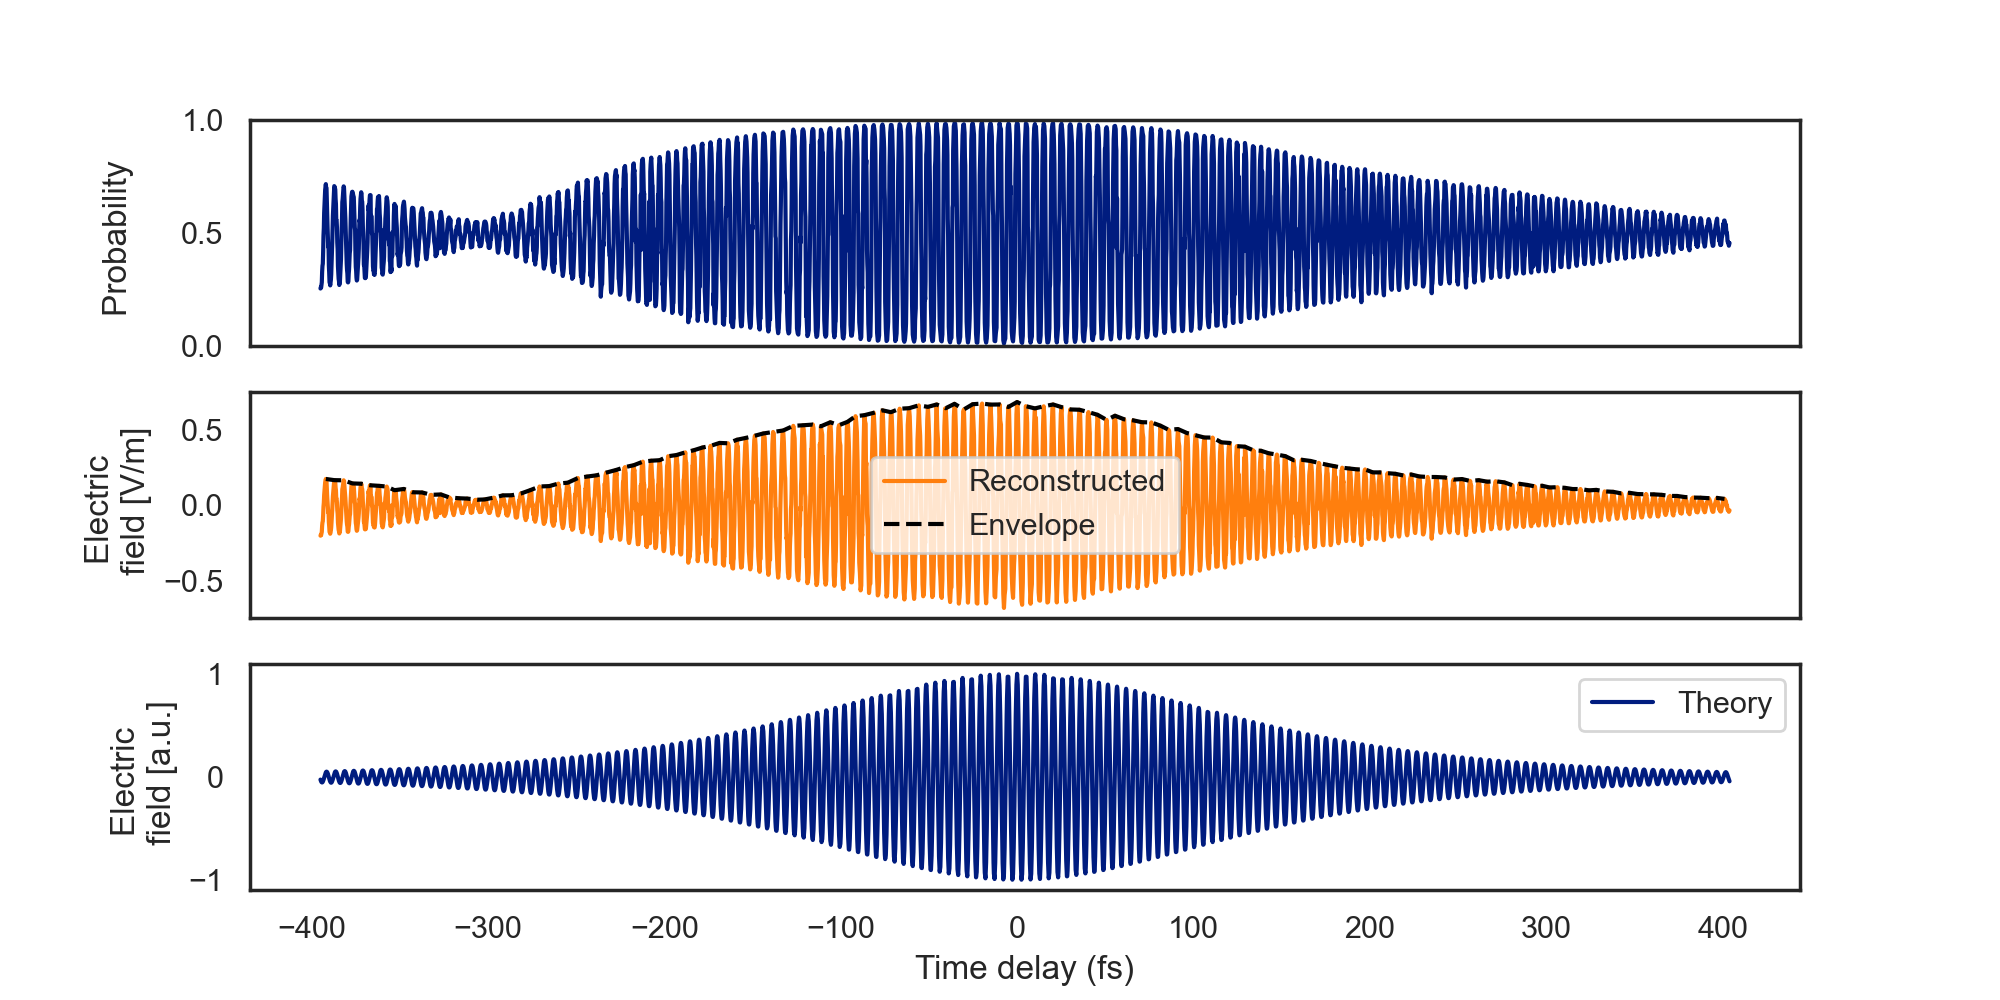

In [35]:
# No fit, just plotting theory vs. experiment

# τ_p = 183e-15 # in femtoseconds (initial pulse length from Toptica)
τ_p = 190e-15 # in femtoseconds (calculated final pulse length through 50mm LiNbO_3)
theoretical_pulse = np.real(pulse_func_sech(expt_times, 1., 0., 1544e-9, τ_p, 0.))

# Extract envelope 
envelope, _ = find_peaks(field_recons, height=0, distance = 10)

fig, ax = plt.subplots(3,1, figsize = (10,5))
ax[0].plot(expt_times*1e15, expt_probs)
ax[0].set_ylim(0,1)
# ax[0].set_xlim(-420, 500)
ax[0].set_ylabel('Probability \n ')
ax[0].set_xticks([])

ax[1].plot(expt_times*1e15, field_recons, color = bias_color, label = 'Reconstructed')
ax[1].plot(expt_times[envelope]*1e15, field_recons[envelope], '--', color = 'black', label = 'Envelope')
ax[1].set_ylabel('Electric \n field [V/m]')
ax[1].set_xticks([])
ax[1].legend()
# ax[1].set_xlim(-420, 500)

ax[2].plot(expt_times*1e15, theoretical_pulse, label = 'Theory')
ax[2].set_xlabel('Time delay (fs)')
ax[2].set_ylabel('Electric \n field [a.u.]')
ax[2].legend()

FWHM experiment = 220.10154816514924 fs
Fit parameters [  0.68058608 -17.09762241 220.10154817]
Fit uncertainty [3.62670973e-05 2.07244056e+00 6.52656940e+00]


<IPython.core.display.Javascript object>


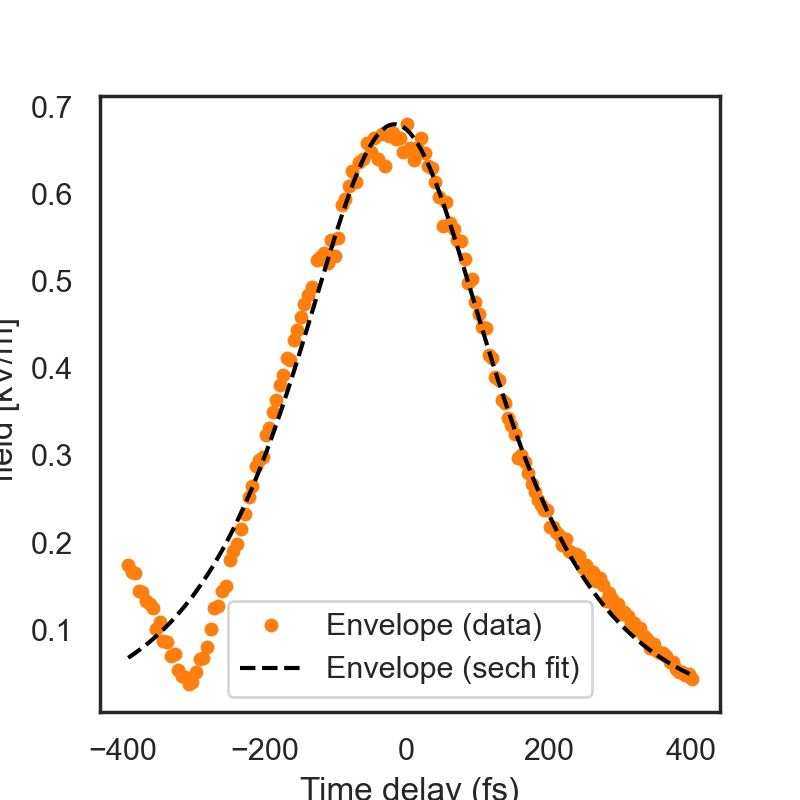

In [36]:
# Times in fs 
expt_times_fs = expt_times*1e15

# Fitting envelope function to extract FWHM 
xdata = expt_times[envelope]*1e15
ydata = field_recons[envelope]

# Clamping t = 0 and scaling
# aarg, pcov = scipy.optimize.curve_fit(pulse_func_sech_envelope, xdata, ydata, p0 = [1.,0.,180], bounds = ([0.999,0.,150],[1.,1e-12,350]))

# No clamping
aarg, pcov = scipy.optimize.curve_fit(pulse_func_sech_envelope, xdata, ydata, p0 = [1.,0.,250])

print("FWHM experiment = {0} fs".format(aarg[2]))

fwhm_stderr = np.diag(pcov)[-1]

print("Fit parameters {0}".format(aarg))
print("Fit uncertainty {0}".format(np.diag(pcov)))

envelope_fit = pulse_func_sech_envelope(xdata, aarg[0], aarg[1], aarg[2])
plt.figure(figsize = (4,4))
plt.plot(xdata, ydata, 'o', color = bias_color, label = 'Envelope (data)', markersize = 4)
plt.plot(xdata, envelope_fit, '--', color = 'black', label = 'Envelope (sech fit)')
plt.xlabel("Time delay (fs)")
plt.ylabel("Electric \n field [kV/m]")
plt.legend()
plt.savefig('piezo-sweep-envelope.svg')

<IPython.core.display.Javascript object>


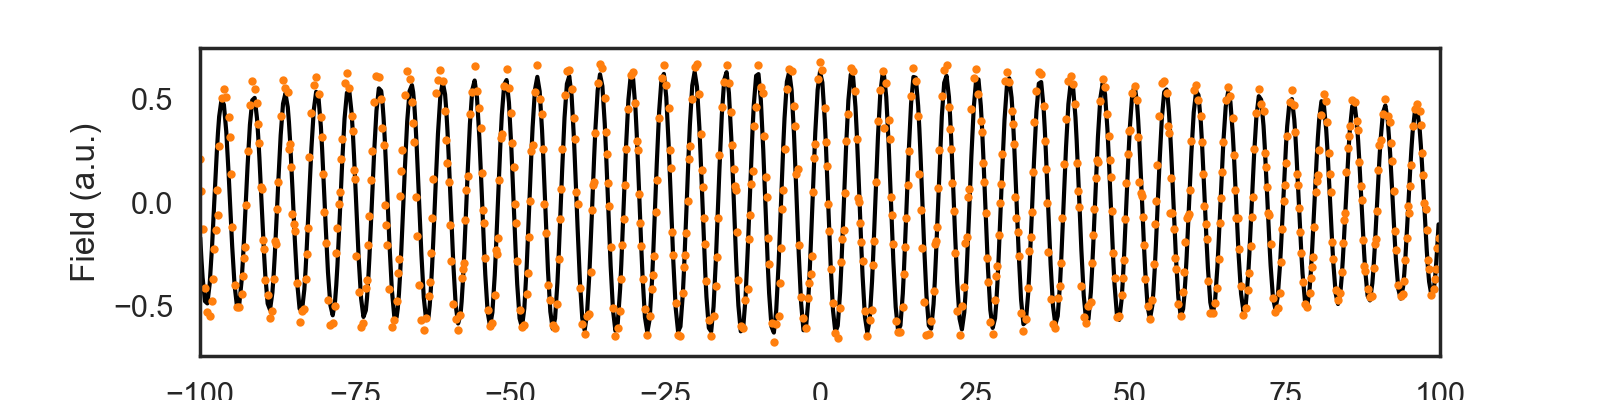

Fit parameters [ 6.36060017e-01 -8.89797024e+00  1.51947655e+09 -2.17365386e+02
 -6.29986614e-02  2.39301030e-05]
Parameter uncertainty 0.01080033698551342 3.751914996770944 221260.63811964495 15.89418911157203 0.013779128119884776 3.4105940364608757e-06


In [37]:
center_window1 = 0
length_window1 = 200

ind1l = np.where(np.abs(expt_times_fs-center_window1+length_window1/2.)==np.min(np.abs(expt_times_fs-center_window1+length_window1/2.)))[0][0]
ind1r = np.where(np.abs(expt_times_fs-center_window1-length_window1/2.)==np.min(np.abs(expt_times_fs-center_window1-length_window1/2.)))[0][0]
window1 = [int(ind) for ind in np.arange(ind1l, ind1r)]

expt_times_fs_to_fit = expt_times_fs[window1]
field_recons_tofit = field_recons[window1]

# Fitting pulse
p0 = [ 9.79502648e-01, -1.24188504e+01,  1.5e9,  183, -7.61739406e-02,  2.94582098e-05]
aarg, pcov = scipy.optimize.curve_fit(pulse_func_sech_chirped, expt_times_fs_to_fit, field_recons_tofit, p0 = p0)

center_pulse_fit = pulse_func_sech_chirped(expt_times_fs_to_fit, *aarg)

plt.figure(figsize = (8,2))
plt.plot(expt_times_fs_to_fit, center_pulse_fit, color = 'black')
plt.plot(expt_times_fs_to_fit, field_recons_tofit, 'o', color = bias_color, markersize = 2.0)
plt.xlabel("Time delay (fs)")
plt.ylabel("Field (a.u.)")
plt.xlim(-100,100)

print("Fit parameters {0}".format(aarg))
print("Parameter uncertainty {0} {1} {2} {3} {4} {5}".format(*np.sqrt(np.diag(pcov))))

In [38]:
def window_wl_fit(center_window1, length_window1):
    ''' Window center and length are in fs '''
    ''' Fits part of the pulse in window to fit wavelength '''

    ind1l = np.where(np.abs(expt_times_fs-center_window1+length_window1/2.)==np.min(np.abs(expt_times_fs-center_window1+length_window1/2.)))[0][0]
    ind1r = np.where(np.abs(expt_times_fs-center_window1-length_window1/2.)==np.min(np.abs(expt_times_fs-center_window1-length_window1/2.)))[0][0]
    window1 = [int(ind) for ind in np.arange(ind1l, ind1r)]

    aarg1, pcov1 = scipy.optimize.curve_fit(sin_func, expt_times_fs[window1], field_recons[window1], p0 = np.array([0, 2., 2*np.pi/5., 0.]))
    err1 = np.sqrt(np.diag(pcov1)[2])
    (wl1, wl1p, wl1m) = (2*np.pi/(aarg1[2]), 2*np.pi/(aarg1[2]-err1), 2*np.pi/(aarg1[2]+err1)) # in fs
    (wl1, wl1p, wl1m) = (c0*wl1*1e-6, c0*wl1p*1e-6, c0*wl1m*1e-6) # in nanometers

    thin_times_fs = np.linspace(np.min(expt_times_fs[window1]), np.max(expt_times_fs[window1]), 10000)

    print("Window 1 - Fit wavelength = {0} +/- {1} {2} nm".format(wl1, wl1p, wl1m))

window_wl_fit(0,10)

Window 1 - Fit wavelength = 1498.8417894099432 +/- 1507.6079498742868 1490.1769833129192 nm


<IPython.core.display.Javascript object>


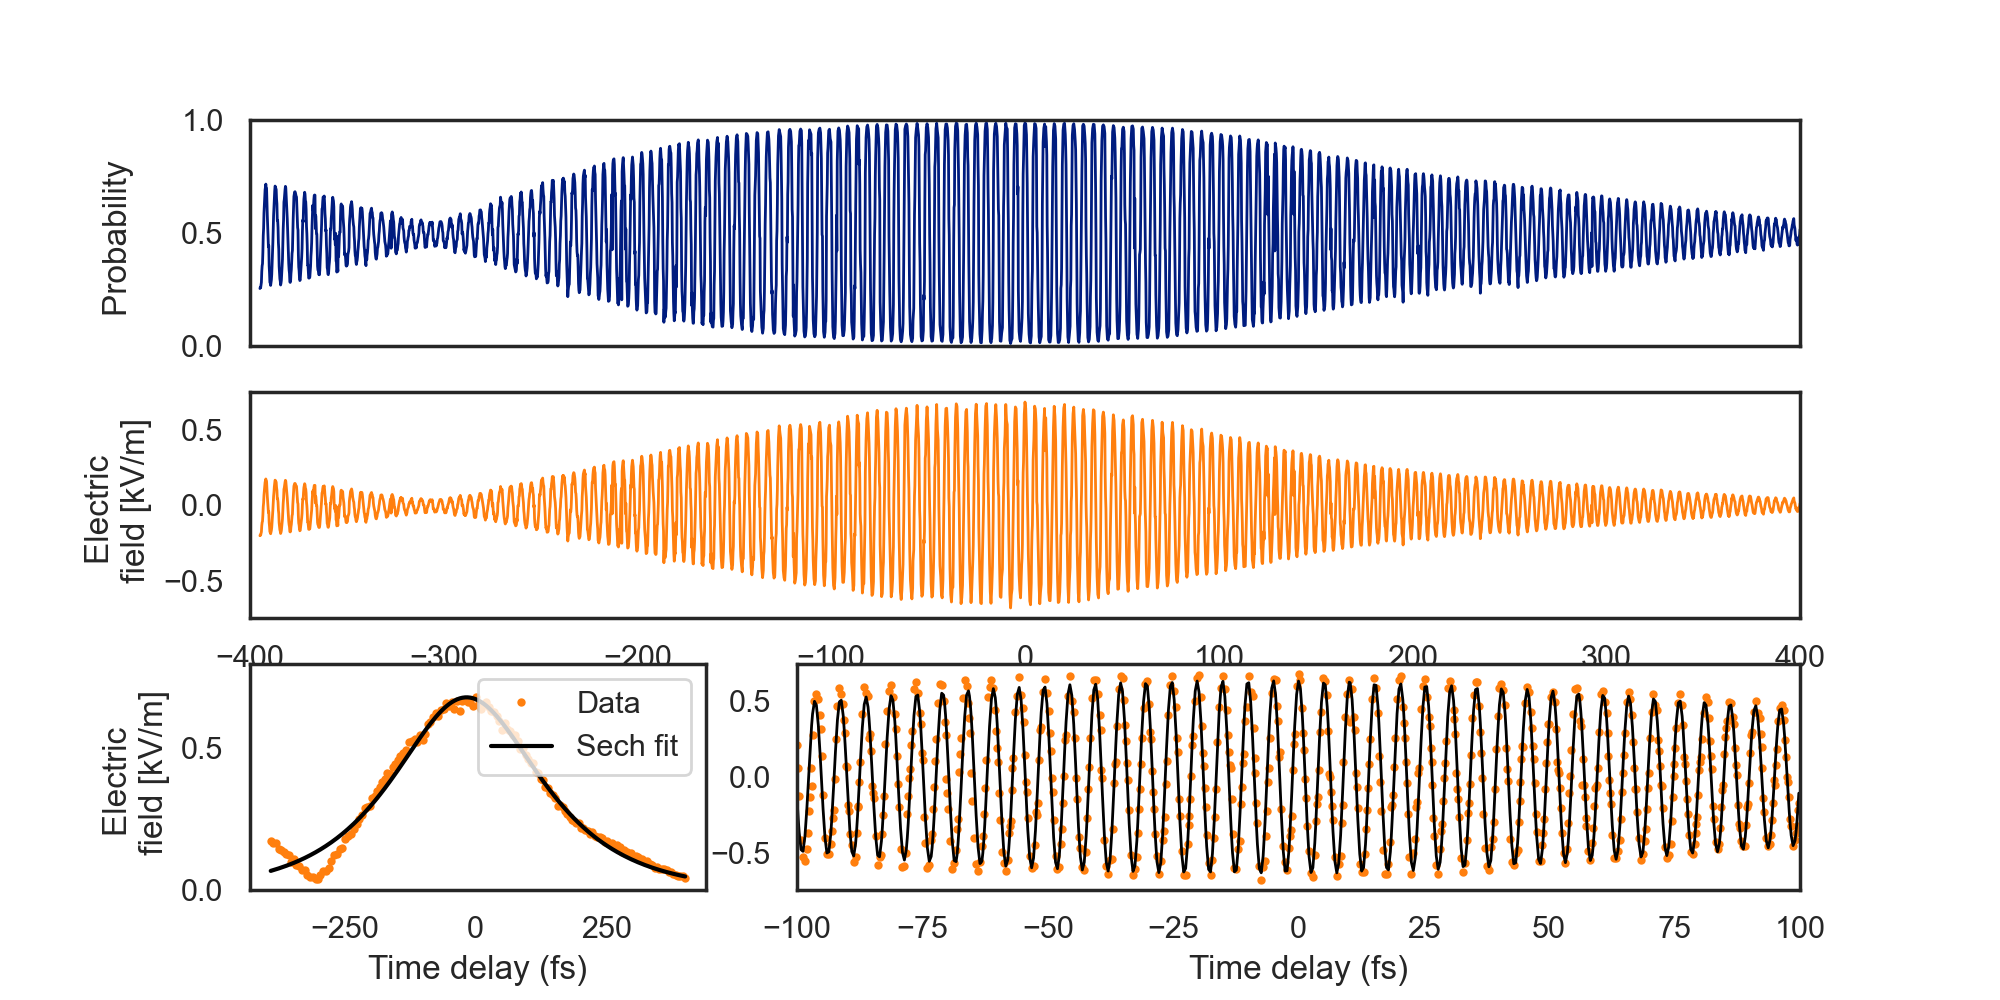

In [44]:
''' Complete Figure 4 '''

fig = plt.figure(constrained_layout=True, figsize = (10,5))

gs = GridSpec(3, 3, figure=fig)
ax0 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1:])

ax0.plot(expt_times*1e15, expt_probs, linewidth = 1.0)
ax0.set_ylim(0,1)
ax0.set_xlim(-400, 400)
ax0.set_ylabel('Probability \n ')
ax0.set_xticks([])

ax1.plot(expt_times*1e15, field_recons, color = bias_color, label = 'Reconstructed', linewidth = 1.0)
# ax1.plot(expt_times[envelope]*1e15, field_recons[envelope], '--', color = 'black', label = 'Envelope')
ax1.set_ylabel('Electric \n field [kV/m]')
# ax1.set_xticks([])
ax1.set_xlabel('Time delay (fs)')
# ax1.legend()
ax1.set_xlim(-400, 400)

ax2.plot(xdata, ydata, 'o', color = bias_color, label = 'Data', markersize = 2.)
ax2.plot(xdata, envelope_fit, color = 'black', label = 'Sech fit')
ax2.set_xlabel("Time delay (fs)")
ax2.set_ylabel('Electric \n field [kV/m]')
ax2.set_ylim(0,0.8)
ax2.legend()

ax3.plot(expt_times_fs_to_fit, field_recons_tofit, 'o', color = bias_color, markersize = 2.0)
ax3.plot(expt_times_fs_to_fit, center_pulse_fit, color = 'black', linewidth = 1.0)

ax3.set_xlabel("Time delay (fs)")
ax3.set_xlim(-100,100);